# 10: Unsupervised learning

In [1]:
%matplotlib inline

import numpy as np
from sklearn.datasets import make_blobs
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

import mylib as my

## Gaussian Mixture Models (GMMs)
The GMMs use the Expectation-Maximization (EM) algorithm which has the following steps:
* Initialize parameters. For the mixing coefficient $\pi$, we can initialize it to $1 / K$, where $K$ is the number of clusters. For $\mu$ we can randomly pick $K$ examples. For the covariance matrix $\boldsymbol{\Sigma}$ we can use the covariance of the training data.

* while not converged:
    * E-step:
    Compute:
    $$r_k^{(i)} = P(z^{(i)} = k | \mathbf{x}^{(i)}) = \frac{\pi_k N(\mathbf{x^{(i)}} | \mathbf{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^K \pi_j N(\mathbf{x^{(i)}} | \mathbf{\mu}_j, \boldsymbol{\Sigma}_j)}$$
    for every data example $\mathbf{x}^{i}$ and cluster $k$
    * M Step: For all clusters $k$, use the $r_k^{(i)}$ to update the model parameters in the below order:

    $$\pi_k = \frac{1}{N} \sum_{i=1}^N r_k^{(i)} $$

    $$\mathbf{\mu}_k = \frac{\sum_{i=1}^N r_k^{(i)} \mathbf{x}^{(i)}}{\sum_{i=1}^N r_k^{(i)}} $$

    $$\boldsymbol{\Sigma}_k = \frac{\sum_{i=1}^N r_k^{(i)} (\mathbf{x}^{(i)} - \mathbf{\mu}_k)(\mathbf{x}^{(i)} -  \mathbf{\mu}_k)^T}{\sum_{i=1}^N r_k^{(i)}} $$
    
There is a possibility that a cluster will have a single point. This will result in a covariance matrix that is not invertible which causes a `singluar matrix` error. We can avoid that by allowing for singular matrices in the `multivariate_normal` function.

### Information criteria
To be able to tell how well the GMM models are doing, use an AIC or BIC criteria, which are calculated as follows:
* $\text{AIC} = -2 \times \text{log_likelihood} \times N + \text{n_parameters} \times log(N)$
* $\text{BIC} = -2 \times \text{log_likelihood} \times N + 2 \times \text{n_parameters}$

where $N$ is the number of examples, $\text{log_likelihood}$ is the mean of $log(\pi N(\mathbf{X} | \mathbf{\mu}, \boldsymbol{\Sigma}))$ and $\text{n_parameters}$ is the number of adjusted parameters (degrees of freedom):

$$\text{n_parameters} = K \times M \times (M + 1) / 2$$

where $M$ is the number of features and $K$ is the number of clusters.

### Convergence
The EM algorithm is iterative and run for as many iterations as the parameter `max_iters`, but that is not needed all the times. So we can use the mean log-likelihood to see if the models have converged.

Let's implement this algorithm.

In [2]:
class GMM:
    def __init__(self, K, max_iters=100):
        self.K = K
        self.max_iters = max_iters
    
    def initialize(self, X):
        self.pi = np.full(shape=self.K, fill_value=1/self.K)
        self.mu = X[np.random.randint(0, len(X), self.K),:]
        self.sigma = np.array([np.cov(X.T) for _ in range(self.K)])
        
    def prob_likelikhood(self, X):
        N = len(X)
        likelihood = np.zeros((N, self.K))
        for i in range(self.K):
            gaussian = st.multivariate_normal(mean=self.mu[i], cov=self.sigma[i], allow_singular=True)
            likelihood[:,i] = gaussian.pdf(X)

        return likelihood * self.pi
        
    def responsibility(self, X):
        numerator = self.prob_likelikhood(X)
        self.likelihood = numerator.sum(axis=1)
        return numerator / numerator.sum(axis=1).reshape(len(X), 1)
    
    def e_step(self, X):
        self.r = self.responsibility(X) 
        
    def m_step(self, X):
        N, M = X.shape
        for k in range(self.K):
            total_r = self.r[:,[k]].sum()
            if total_r == 0:
                total_r = 0.000001
            self.mu[k] = (X * self.r[:,[k]]).sum(axis=0) / total_r
            self.sigma[k] = np.cov(X.T, aweights=(self.r[:,[k]]/total_r).flatten(), bias=True)

    def fit(self, X):
        self.initialize(X)
        prev_ll = -1
        p_mu = np.zeros(self.mu.shape)
        itr = 1
        ll = 0
        while itr <= self.max_iters and not(np.isclose(ll, prev_ll).all()):
            prev_ll = ll
            self.e_step(X)
            self.m_step(X)
            ll = np.log(self.likelihood).mean()
            itr += 1

        return self
        
    def predict(self, unseen):
        return np.argmax(self.responsibility(unseen), axis=1)
        
    def params_and_loglikelihood(self, M):
        """Returns:
            - the number of adjustuble parameters and 
            - the mean of the log-likelihood (the score)
        """
        return self.K * M * (M + 1) / 2., np.log(self.likelihood).mean()
    
    def bic(self, X):
        N, M = X.shape
        params, log_likelihood = self.params_and_loglikelihood(M)
        return (-2 * log_likelihood * N + params * np.log(N))
    
    def aic(self, X):
        N, M = X.shape
        params, log_likelihood = self.params_and_loglikelihood(M)
        return -2 * log_likelihood * N + 2 * params

### Testing and visualizing GMMs
Here is some data to test with:

Text(0.5, 1.0, 'Original dataset')

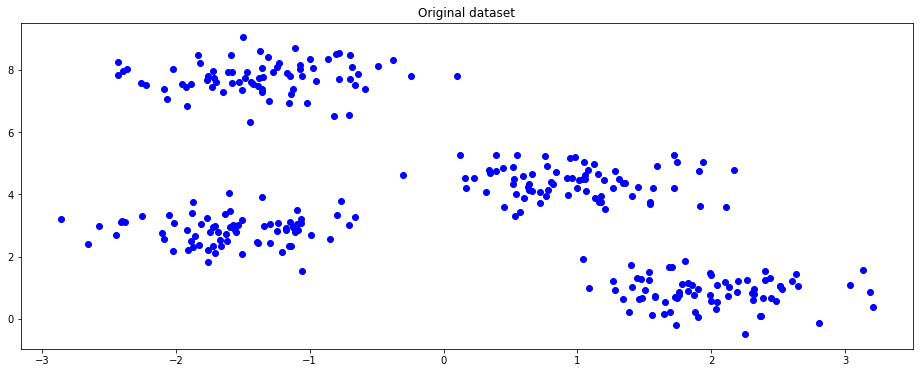

In [3]:
fig=plt.figure(figsize=(16,6))
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.50, random_state=0)
plt.scatter(X[:,0], X[:,1], c='b')
plt.title("Original dataset")

Here is are the clusters learned by GMM; their centers are marked in read.

Text(0.5, 1.0, 'Original dataset with learned centers')

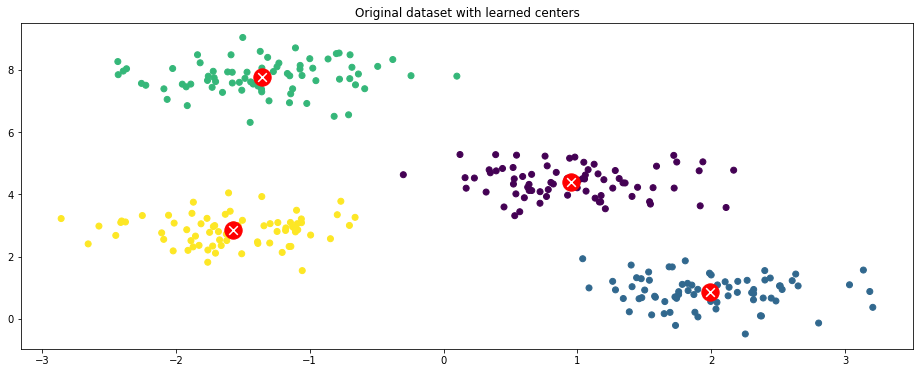

In [7]:
gmm = GMM(4).fit(X)
fig=plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(X[:,0], X[:,1], c=gmm.predict(X[:, :]))
ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], marker='o', s=300, facecolors='red', edgecolors='r', color='r')
ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], marker='x', c="w", s=75)



plt.title("Original dataset with learned centers")

It's imperative to understand that this is not classification. This is unsupervised learning and the colors of the last plot might not match the one before it.

To visualize the clusters that the GMM learns, here is a simple function for plotting ellipses around the identified clusters.

In [8]:
from matplotlib.patches import Ellipse

def plot_guasian_covariance(X, n_std=2, ax=None, **kwargs):
    """
    Plots an ellipse based on the mean and covariance of the given 
    2-dimentional data examples.

    Parameters:
        X : An 2-dimentional array of data examples.
        n_std : The # of standard deviations to include n the ellipse. 
                Controls the radius of the ellipse.
        ax : The matplotlib axis to plot the ellipse on, if any.
        kwargs: Additional keyword arguments to pass to matplotlib Ellipse.
    """
    # Mean and covariance of the data
    mu = X.mean(axis=0)
    cov = np.cov(X, rowvar=False)

    # Getting the eigen vectors and values of the cov matrix, just like in PCA
    eig_vals, eig_vecs = np.linalg.eig(cov)

    # Sort eigenvectors by decreasing eigenvalues
    eig_vecs = eig_vecs.T
    sortedIndices = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[sortedIndices]
    eig_vecs = eig_vecs[sortedIndices]
        
    theta = np.degrees(np.arctan2(*eig_vecs[:,0][::-1]))
    width, height = 2 * n_std * np.sqrt(eig_vals)
    ellipse = Ellipse(xy=mu, width=width, height=height, angle=theta, **kwargs)

    if ax is None:
        ax = plt.gca()
        
    ax.add_artist(ellipse)

Let's call this function.

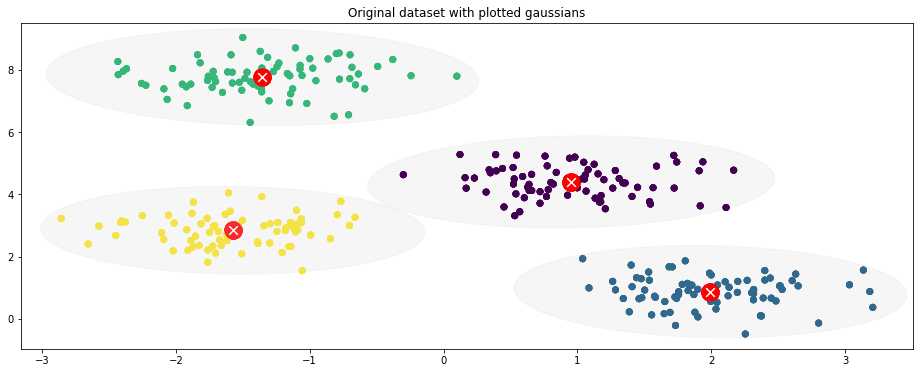

In [9]:
fig = plt.figure(figsize=(16, 6))
for i in range(4):
    examples = X[gmm.predict(X) == i, :]
    
    plt.scatter(X[:,0], X[:,1], c=gmm.predict(X[:, :]))
    plt.scatter(gmm.mu[:, 0], gmm.mu[:, 1], marker='o', s=300, facecolors='red', edgecolors='r', color='r')
    plt.scatter(gmm.mu[:, 0], gmm.mu[:, 1], marker='x', c="w", s=75)
#     plt.scatter(gmm.mu[:,0], gmm.mu[:,1], c='r', marker='x', s=75)
    plot_guasian_covariance(examples, n_std=3, alpha=.2, color='lightgrey')
plt.title("Original dataset with plotted gaussians");

We can also plot the decision regions to visualize these clusters

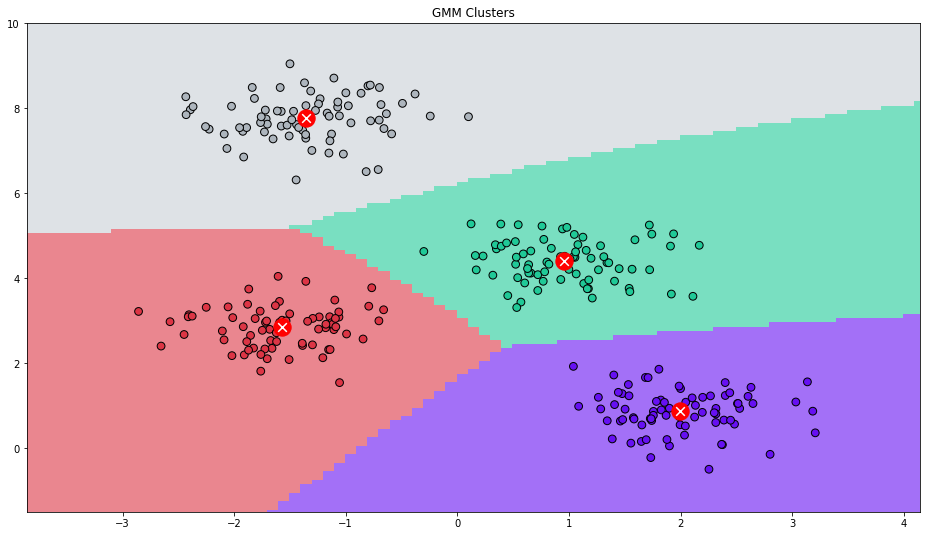

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
my.plot_decision_regions(X, gmm.predict(X).reshape(len(X), 1), gmm, resolution=0.1, title="GMM Clusters", ax=ax)
ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], marker='o', s=300, facecolors='red', edgecolors='r', color='r')
ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], marker='x', c="w", s=75)

### What should $K$ be?
There are many ways to find out the best value for $K$, here we list three: the AIC and BIC information criteria as the silhouette score. Let's try multiple GMM models and plot their AIC and BIC.

Text(0, 0.5, 'Information criterion')

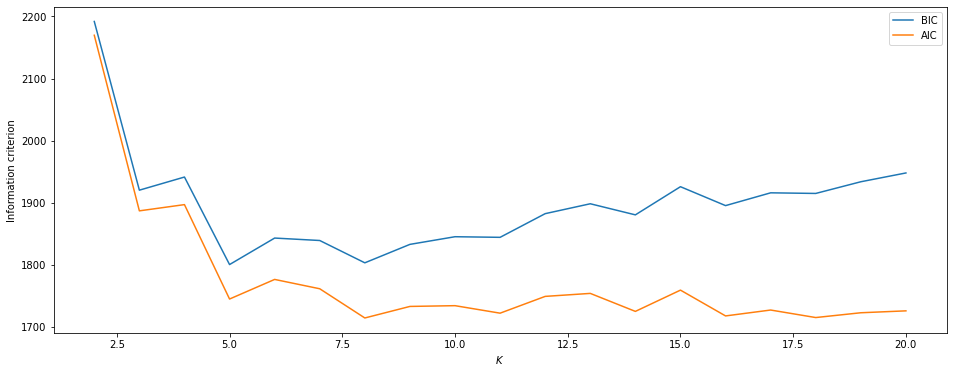

In [13]:
K = np.arange(2, 21)
models = [ GMM(k).fit(X) for k in K ]
fig=plt.figure(figsize=(16,6))
plt.plot(K, [m.bic(X) for m in models], label='BIC')
plt.plot(K, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('$K$')
plt.ylabel('Information criterion')

Looking at the AIC and BIC plot, we look for the model with the least AIC and BIC values, which is the one with  4 clusters.

### CHALLENGE A
For each of the 20 models above, compute the MSE (the mean squared error) by computing the mean of all the distances between each example and its assigned cluster centroid. Plot these mean distances against the number of components. 

In [ ]:
def find_error(shiz, classer):
    error_sum = 0
    H= np.array(classer.predict(shiz), copy=False, subok=True, ndmin=2).T
    data = np.append(X,H, axis=1)
    #data= data[data[:, 2].argsort()]
    for i in data:
        error_sum += (np.linalg.norm(i[:2] - classer.mu[i[2].astype(int)]))

    return error_sum/data.shape[0]

find_error(X,gmm)

0.6191490480370009

Text(0, 0.5, 'Error')

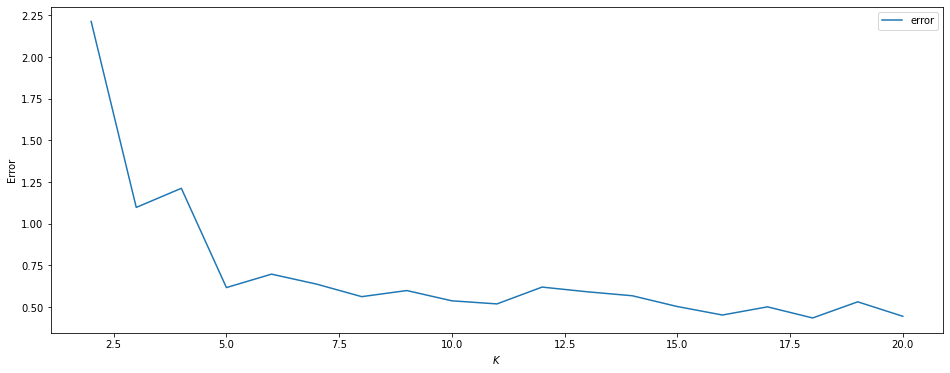

In [17]:
K = np.arange(2, 21)
fig=plt.figure(figsize=(16,6))
# plt.plot(K, [m.bic(X) for m in models], label='BIC')
# plt.plot(K, [m.aic(X) for m in models], label='AIC')
plt.plot(K,[find_error(X,m) for m in models],label='error')
plt.legend(loc='best')
plt.xlabel('$K$')
plt.ylabel('Error')# TODO

### The silhouette score
For a data example $i$ in the cluster $C_i$, the silhouette score is defined as:
$${\displaystyle s(i)={\frac {b(i)-a(i)}{\max\{a(i),b(i)\}}}} \text{if}\ {\displaystyle |C_{i}|>1}$$
where:
* ${\displaystyle a(i)={\frac {1}{|C_{i}|-1}}\sum _{j\in C_{i},i\neq j}distance(i,j)}$

    is the mean distance between $i$ and all other data points in the same cluster. $a(i)$ can be thought of as a measure of how well $i$ is assigned to its cluster.

* ${\displaystyle b(i)=\min _{k\neq i}{\frac {1}{|C_{k}|}}\sum _{j\in C_{k}}distance(i,j)}$
    is the smallest mean distance of $i$ to all points in other clusters than its own. The cluster with this smallest $b(i)$ is the next best fit cluster for point $i$.

The mean $s(i)$ over all examples of the entire dataset is a measure of how appropriately the data have been clustered. Its values range between $-1$ and $+1$.

The model with the maximum mean $s(i)$ is best.

In [ ]:
from sklearn.metrics import silhouette_score
K = np.arange(2, 21)
models = [ GMM(k).fit(X) for k in K ]
fig=plt.figure(figsize=(16,6))
plt.plot(K, [silhouette_score(X, m.predict(X)) for m in models])
plt.xlabel('$K$')
plt.ylabel('Silhouette score')

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

<Figure size 1152x432 with 0 Axes>

## K-means clustering
This is a simple and popular clustering algorithm that given a number of clusters $K$:
* Initializes the $K$ clusters to random data examples
* Repeats until convergence:
    * Step 1 (equivalent to e_step): assigns each data example to the cluster with the closest center.
    * Step 2 (equivalent to m_step): updates the centers by moving the position of the center 
        $\mu_k$ to the mean of the examples in that cluster $C_k$: 
    
        $\mu_k = \frac{\sum_{n=1}^{N} \mathbf{x}_n}{N_k}$
        
        where $N_k$ is the number of examples in cluster $C_k$
        
Here we use the Euclidean distance to measure closeness. Here is a class implementing this algorithm.

In [ ]:
class KMeans:
    def __init__(self, K, max_iters=100):
        self.K = K
        self.max_iters = max_iters
    
    def initialize(self, X):
        self.centers = X[np.random.randint(0, len(X), self.K),:]
        self.assignments = np.zeros(len(X))

    def wcss(self, X):
        """The within-clas sum of squares is the sum of squared distances of 
            samples to their closest cluster center."""
        return np.sum((X - self.centers[self.predict(X)])**2)
    
    def aic(self, X):
        wcss = self.wcss(X)
        K, M = self.centers.shape

        return(wcss + 2 * M * K)
        
    def e_step(self, X):
        """Assignes each example to the closest center"""
        N, M = X.shape
             
        distances = np.array([np.sum((X - c)**2, axis=1) for c in self.centers])
        self.assignments = distances.T.argmin(axis=1)
    
    def m_step(self, X):
        for k in range(self.K):
            cluster = np.where(self.assignments==k,1,0)
            cluster_count = sum(cluster) 
            if cluster_count > 0:
                self.centers[k,:] = np.sum(X * cluster.reshape(len(X), 1), axis=0) /cluster_count
        
    def fit(self, X):
        N, M = X.shape
        self.initialize(X)
        itr = 1
        prev_centers = np.zeros((self.K, M))
        while itr <= self.max_iters and np.sum(prev_centers- self.centers) != 0:
            prev_centers = self.centers.copy()
            
            self.e_step(X)
            self.m_step(X)
            itr += 1
            
        return self

    def predict(self, unseen):
        N, M = unseen.shape
        distances = np.array([np.sum((unseen - c)**2, axis=1) for c in self.centers])
        return distances.T.argmin(axis=1)

### Testing the algorithm
Let's test the above `KMeans` class using the same dataset we used for testing `GMM`. Here is the original dataset again.

Text(0.5, 1.0, 'Original dataset')

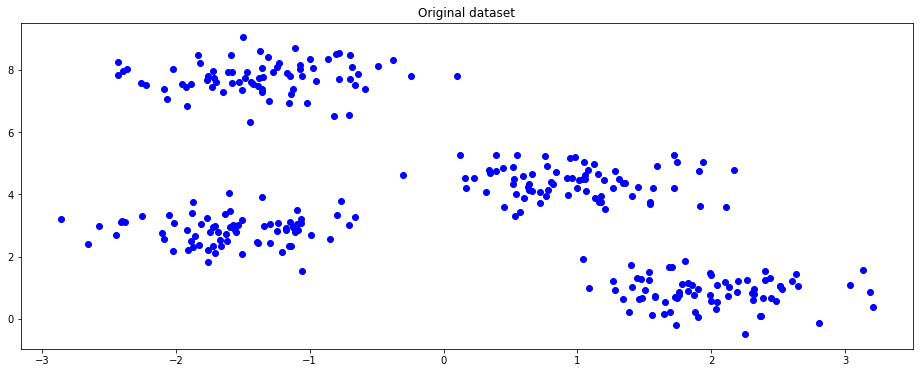

In [ ]:
fig=plt.figure(figsize=(16,6))
plt.scatter(X[:,0], X[:,1], c='b')
plt.title("Original dataset")

And here are the `KMeans` clusters and their assigned examples. **Do you see mismatch between the learned clusters and the classes of the original dataset?**

Text(0.5, 1.0, 'Original dataset with learned centers')

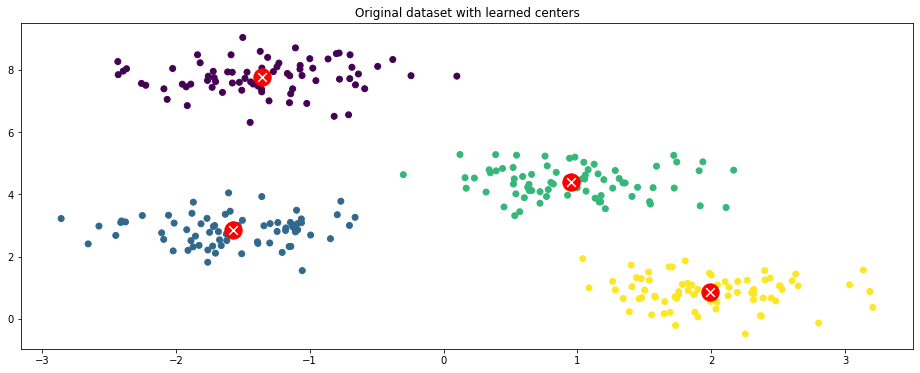

In [ ]:
km = KMeans(4).fit(X)
fig=plt.figure(figsize=(16,6))
plt.scatter(X[:,0], X[:,1], c=km.predict(X))

plt.scatter(km.centers[:, 0], km.centers[:, 1], marker='o', s=300, facecolors='red', edgecolors='r', color='r')
plt.scatter(km.centers[:,0], km.centers[:,1], c="w", marker="x", s=75)


plt.title("Original dataset with learned centers")

## Visualizing the clusters
We can plot the decision regions to visualize the clusters

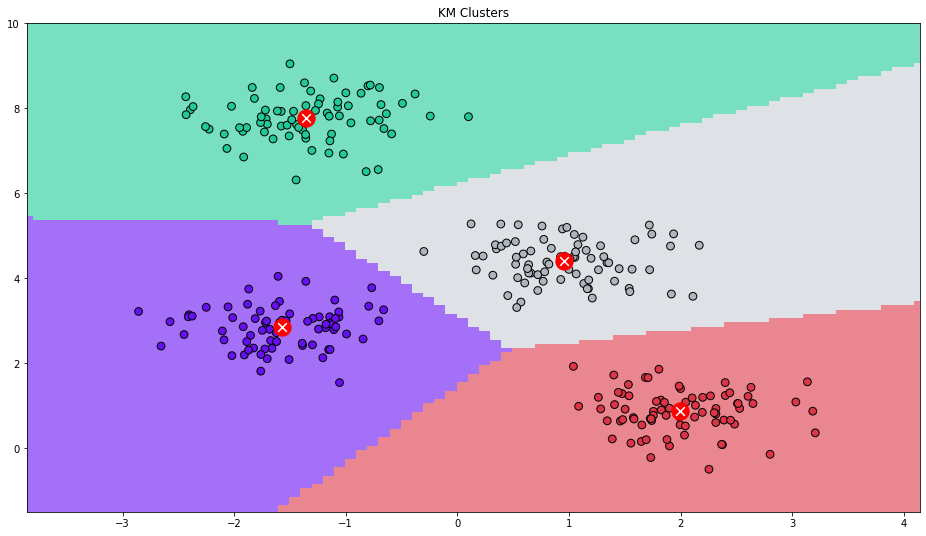

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
my.plot_decision_regions(X, km.predict(X).reshape(len(X), 1), km, resolution=0.1, title="KM Clusters", ax=ax)
ax.scatter(km.centers[:, 0], km.centers[:, 1], marker='o', s=300, facecolors='red', edgecolors='r', color='r')
ax.scatter(km.centers[:,0], km.centers[:,1], c="w", marker="x", s=75)

### What should $K$ be?
Like GMMs, there are many ways to find out the best value for $K$. We can use the within-class sum of squares error (WCSS) or the AIC which defined as:

$$ \text{AIC}\ =\  \text{WCSS} + 2 \times M \times K$$

where $M$ is the number of features and $K$ is the number of clusters.

Text(0.5, 0, '$K$')

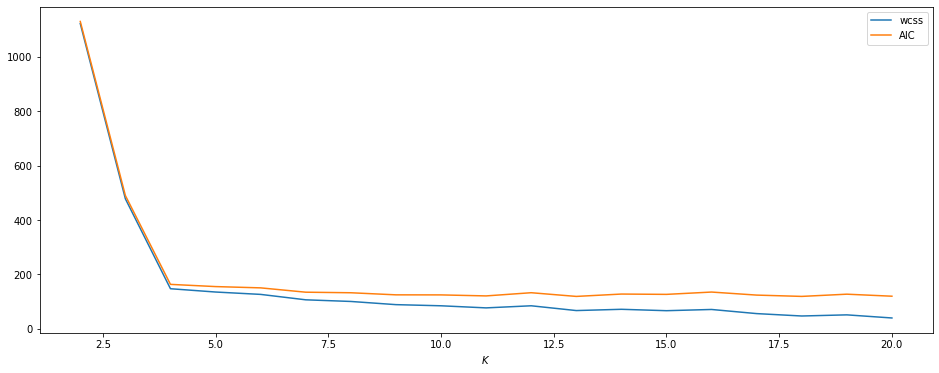

In [ ]:
K = np.arange(2, 21)
models = [ KMeans(k).fit(X) for k in K ]
fig=plt.figure(figsize=(16,6))
plt.plot(K, [m.wcss(X) for m in models], label='wcss')
plt.plot(K, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('$K$')

We can also use the silhouette score.

Text(0, 0.5, 'Silhouette score')

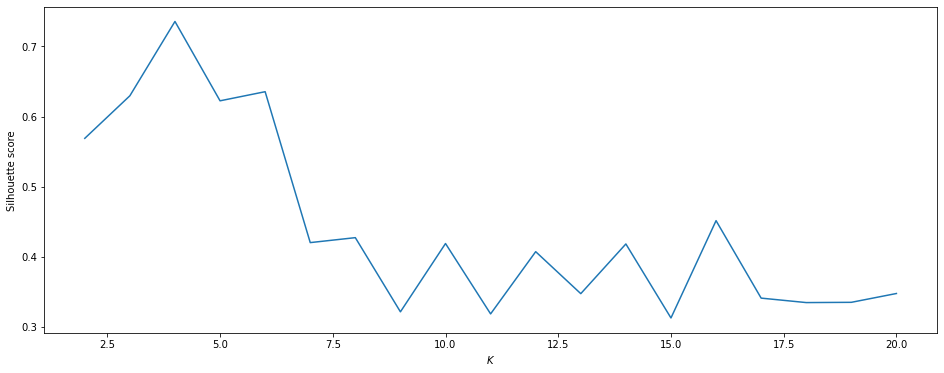

In [ ]:
fig=plt.figure(figsize=(16,6))
plt.plot(K, [silhouette_score(X, m.predict(X)) for m in models])
plt.xlabel('$K$')
plt.ylabel('Silhouette score')

### CHALLENGE B
Apply K-means clustering to the IRIS dataset. Start by using PCA (from Notebook 09) to reduce it to 2D. Then apply KMeans clustering to the PCA-transformed data. Plot the data and use the WCSS, AIC, and the silhouette score to determine the best value for $K$.

In [ ]:
# TODO